In [ ]:
import numpy as np
import pandas as pd
from pandas import plotting

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import fowlkes_mallows_score


plt.style.use('fivethirtyeight')

import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Ведение**

**Тема**

Я выбрал близкую мне тему : музыка и ее история. Изучая различные исторические статьи на тему развитиия цифровой музыки, пиратства и в целом музыкального бизнеса, мне пришла мысль, а могут ли любимые жанры музыки зависеть от уровня счастья в стране, который в свою очередь является совокупностью показателей уровня зарплат, ВВП страны и в целом ее экономической стабильности.<br>
В контексте всей работы за нулевую гипотезу принимаем утверждение, что индекс уровня счастья, как совокупность нескольких фаторов, не имеет прямой корреляции с популярными жанрами музыки в стране.<br>
Попробуем подтвердить или опровегрнуть это утверждение.

**Описание датасетов**

Ссылка на датасет со странами и их показателями.
https://www.kaggle.com/datasets/ajaypalsinghlo/world-happiness-report-2021/data

Выбрал этот датасет т.к. он довольно точно отображает данные из других источников, которые я изучил. С этого датасета мы попробуем взять максимум. Начнем с метода главных компонент для уменьшения размерности и далее попробуем класстеризовать страны. Скорее всего, границы кластеров будут размытые, т.к. стран много и их показатели разняться не так сильно, чтоб четко их разграничивать, но я надеюсь, что метод главных компонент поможет выделить хотя бы 3-4 группы по совокупности показателей. Далее уже можно будет посмотреть, какие показатели сильнее влияли на рассчет компонентов.

Датасет с данными по жанрам музыки.
https://www.kaggle.com/datasets/marshalll3302/favorite-music-genres-by-country

Найти статистику подобной тематики оказалось довольно трудно, т.к. не все сервисы стриминга музыки публикуют такие данные и, если они и есть, то довольно скудные и чаще всего состоят из топов исполнителей или отдельных треков, что довольно трудно разбить по жанрам. Самый простой пример: на разных стримингах могут отличаться написание названий жанров, кто-то может делить тот же рок на поджанры и т.д. Поэтому для более точного распределения, скорее всего,  потребуется долгая ручная разметка более объемных данных, спарсенных из различных источников. <br>
Попробуем этот датасет, собранный энтузиастом и проверим, будет ли корреляция между уровнем счастья и любимыми жанрами музыки в странах. <br>
<br>
Кол-во стран будет ограничено датасетом с музыкой, т.к. там представлены страны, где официально работает Spotify и данные взяты и сгруппированы из его статистики. Это уменьшает данные для обучения, но надо от чего-то отталкиваться.

#**Визуализация и обработка данных.**

In [ ]:
world_happ = pd.read_csv('/content/drive/My Drive/ProductStar/Диплом/World Happiness Report.csv')
music = pd.read_csv('/content/drive/My Drive/ProductStar/Диплом/musicbycontr.csv')

##Датасет с индексом счастья##

In [ ]:
world_happ.head(5)

,Country Name,Regional Indicator,Year,Life Ladder,Log GDP Per Capita,Social Support,Healthy Life Expectancy At Birth,Freedom To Make Life Choices,Generosity,Perceptions Of Corruption,Positive Affect,Negative Affect,Confidence In National Government
0,Afghanistan,South Asia,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.167652,0.881686,0.414297,0.258195,0.612072
1,Afghanistan,South Asia,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.190809,0.850035,0.481421,0.237092,0.611545
2,Afghanistan,South Asia,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.121316,0.706766,0.516907,0.275324,0.299357
3,Afghanistan,South Asia,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.163571,0.731109,0.479835,0.267175,0.307386
4,Afghanistan,South Asia,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.237588,0.775620,0.613513,0.267919,0.435440


In [ ]:
world_happ.describe()

,Year,Life Ladder,Log GDP Per Capita,Social Support,Healthy Life Expectancy At Birth,Freedom To Make Life Choices,Generosity,Perceptions Of Corruption,Positive Affect,Negative Affect,Confidence In National Government
count,2199.000000,2199.000000,2179.000000,2186.000000,2145.000000,2166.000000,2126.000000,2083.000000,2175.000000,2183.000000,1838.000000
mean,2014.161437,5.479226,9.389766,0.810679,63.294583,0.747858,0.000096,0.745195,0.652143,0.271501,0.483999
std,4.718736,1.125529,1.153387,0.120952,6.901104,0.140150,0.161083,0.185837,0.105922,0.086875,0.193071
min,2005.000000,1.281271,5.526723,0.228217,6.720000,0.257534,-0.337527,0.035198,0.178886,0.082737,0.068769
25%,2010.000000,4.646750,8.499764,0.746609,59.119999,0.656528,-0.112116,0.688139,0.571684,0.207660,0.332549
50%,2014.000000,5.432437,9.498955,0.835535,65.050003,0.769821,-0.022671,0.799654,0.663063,0.260671,0.467140
75%,2018.000000,6.309460,10.373216,0.904792,68.500000,0.859382,0.092070,0.868827,0.737936,0.322894,0.618846
max,2022.000000,8.018934,11.663788,0.987343,74.474998,0.985178,0.702708,0.983276,0.883586,0.704590,0.993604


Как видно, самый ранний год 2005, самый поздний 2022. Большинство данных укладывается в промежуток 2010-2018 года. <br> Так же видно, что самый низкий индекс счастья чуть больше 1, самый высокий 8. В среднем же он в диапазоне 4-6. <br>Всего в датасете 2199 записей, но большинство стран повторяются. Этот аспект нужно будет учесть в будущем, как и разброс по годам.

In [ ]:
world_happ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2199 entries, 0 to 2198
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Country Name                       2199 non-null   object 
 1   Regional Indicator                 2087 non-null   object 
 2   Year                               2199 non-null   int64  
 3   Life Ladder                        2199 non-null   float64
 4   Log GDP Per Capita                 2179 non-null   float64
 5   Social Support                     2186 non-null   float64
 6   Healthy Life Expectancy At Birth   2145 non-null   float64
 7   Freedom To Make Life Choices       2166 non-null   float64
 8   Generosity                         2126 non-null   float64
 9   Perceptions Of Corruption          2083 non-null   float64
 10  Positive Affect                    2175 non-null   float64
 11  Negative Affect                    2183 non-null   float

Как видно, больше всего пропусков в столбце "Confidence In National Goverment'. Я попробую заполнить пустые значения с помощью модели регрессии. Обучим модель на имеющихся данных, и заполним пропуски. В других столбцах пропусков меньше и их просто удалим, т.к. там не такое значимое количество.

Проверим топ-5 стран с самым выскоим уровнем счаться независимо от года.

In [ ]:
world_happ.sort_values('Life Ladder', ascending=False).head(5)

,Country Name,Regional Indicator,Year,Life Ladder,Log GDP Per Capita,Social Support,Healthy Life Expectancy At Birth,Freedom To Make Life Choices,Generosity,Perceptions Of Corruption,Positive Affect,Negative Affect,Confidence In National Government
505,Denmark,Western Europe,2005,8.018934,10.849012,0.972372,68.300003,0.971135,NaN,0.236522,0.776689,0.153672,0.668683
507,Denmark,Western Europe,2008,7.970892,10.877718,0.953912,68.959999,0.969788,0.267880,0.247505,0.759462,0.163091,0.665934
635,Finland,Western Europe,2020,7.889350,10.767303,0.961621,71.074997,0.962424,-0.121018,0.163636,0.747939,0.192898,0.808633
633,Finland,Western Europe,2018,7.858107,10.779966,0.962155,70.925003,0.937807,-0.131462,0.198605,0.748826,0.181781,0.555102
506,Denmark,Western Europe,2007,7.834233,10.888726,0.954201,68.739998,0.932086,0.235808,0.206006,0.777936,0.194324,0.592506


Картина выглядит правдоподобно, т.к. из года в год лидеры не сильно меняются и это так раз Финляyдия и Дания, поэтому датасету можно верить.
Теперь попробуем отобрать данные для анализа.

##Обработка пропусков##

In [ ]:
world_happ = world_happ.dropna(subset=['Country Name', 'Regional Indicator', 'Year', 'Life Ladder',
       'Log GDP Per Capita', 'Social Support',
       'Healthy Life Expectancy At Birth', 'Freedom To Make Life Choices',
       'Generosity', 'Perceptions Of Corruption', 'Positive Affect',
       'Negative Affect' ])

In [ ]:
world_happ.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1874 entries, 0 to 2198
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Country Name                       1874 non-null   object 
 1   Regional Indicator                 1874 non-null   object 
 2   Year                               1874 non-null   int64  
 3   Life Ladder                        1874 non-null   float64
 4   Log GDP Per Capita                 1874 non-null   float64
 5   Social Support                     1874 non-null   float64
 6   Healthy Life Expectancy At Birth   1874 non-null   float64
 7   Freedom To Make Life Choices       1874 non-null   float64
 8   Generosity                         1874 non-null   float64
 9   Perceptions Of Corruption          1874 non-null   float64
 10  Positive Affect                    1874 non-null   float64
 11  Negative Affect                    1874 non-null   float64
 1

In [ ]:
# регрессия для пропусков

# копируем строки с пропусками и без для создания выборок
test = world_happ[world_happ['Confidence In National Government'].isnull()].copy()
train = world_happ.dropna().copy()

# удаляем ненужные столбцы со строковыми форматами данных и годом
X_train = train.drop(['Country Name', 'Regional Indicator', 'Year','Confidence In National Government'], axis = 1)
X_test = test.drop(['Country Name', 'Regional Indicator', 'Year','Confidence In National Government'], axis = 1)
# оставляем столбец с целевой переменной
y_train = train['Confidence In National Government']
# обучаем модель
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
# прогнозируем и заполняем пропуски
y_pred = lr_model.predict(X_test)
test['Confidence In National Government'] = y_pred

In [ ]:
# объединяем все в один датасет
world_happ_lr = pd.concat([train, test])
world_happ_lr.sort_index(inplace = True)
world_happ_lr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1874 entries, 0 to 2198
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Country Name                       1874 non-null   object 
 1   Regional Indicator                 1874 non-null   object 
 2   Year                               1874 non-null   int64  
 3   Life Ladder                        1874 non-null   float64
 4   Log GDP Per Capita                 1874 non-null   float64
 5   Social Support                     1874 non-null   float64
 6   Healthy Life Expectancy At Birth   1874 non-null   float64
 7   Freedom To Make Life Choices       1874 non-null   float64
 8   Generosity                         1874 non-null   float64
 9   Perceptions Of Corruption          1874 non-null   float64
 10  Positive Affect                    1874 non-null   float64
 11  Negative Affect                    1874 non-null   float64
 1

##**Корреляция и РСА**##

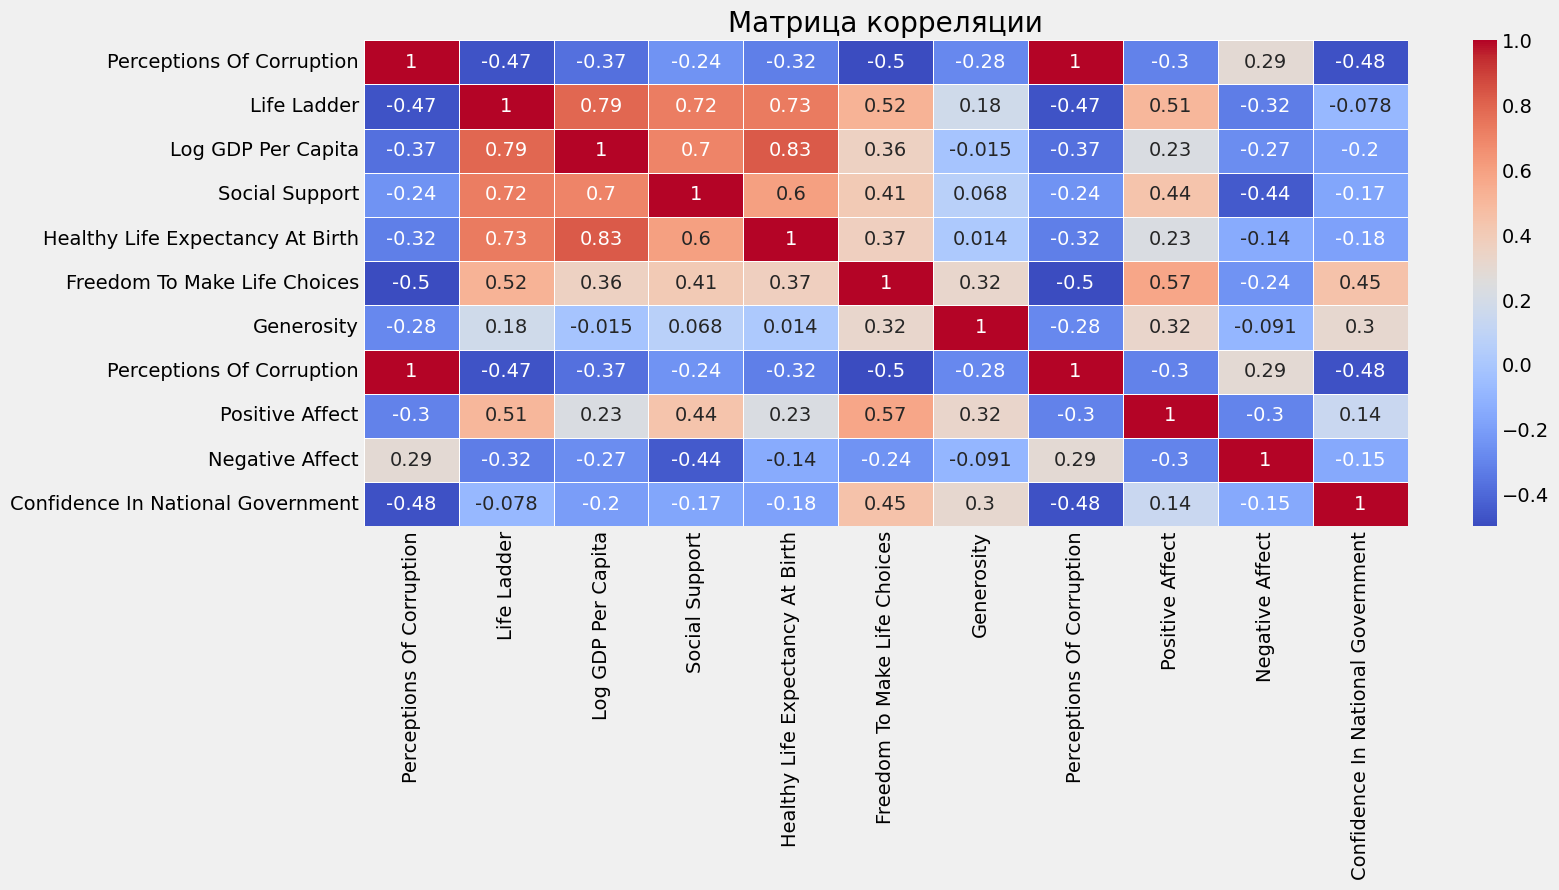

In [ ]:
df = world_happ_lr[['Perceptions Of Corruption', 'Life Ladder',
                                      'Log GDP Per Capita',
                                      'Social Support',
                                      'Healthy Life Expectancy At Birth',
                                      'Freedom To Make Life Choices',
                                      'Generosity',
                                      'Perceptions Of Corruption',
                                      'Positive Affect',
                                      'Negative Affect',
                                      'Confidence In National Government']]

correlation_matrix = df.corr()
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Матрица корреляции")
plt.show()

Я проверил, как будет меняться кореляция признака, который заполняли линейной регрессией, до и после заполнения. Показатели изменились в пределах 0.01-0.02 где-то в большую, где-то в меньшую сторону. В любом случае, это маленькое значение, что косвенно дает представление о точности заполнения регрессией.

In [ ]:
# находим собственные числа
eigenvalues, _ = np.linalg.eig(correlation_matrix)

# выводим результат
print("Собственные числа:", eigenvalues)

Собственные числа: [ 4.68977327e+00  2.25357486e+00  1.13337078e+00  9.14348929e-01
  6.72438504e-01  5.11898011e-01 -2.20834681e-16  2.79176685e-01
  2.31523950e-01  1.81965942e-01  1.31929057e-01]


Вспоминаем критерии выбора/отсеивания факторов. Критерий Кайзера – число факторов равно числу линейных комбинаций, собственные значения которых больше 1.
Построим график каменистой осыпи и посмотрим точку перегиба

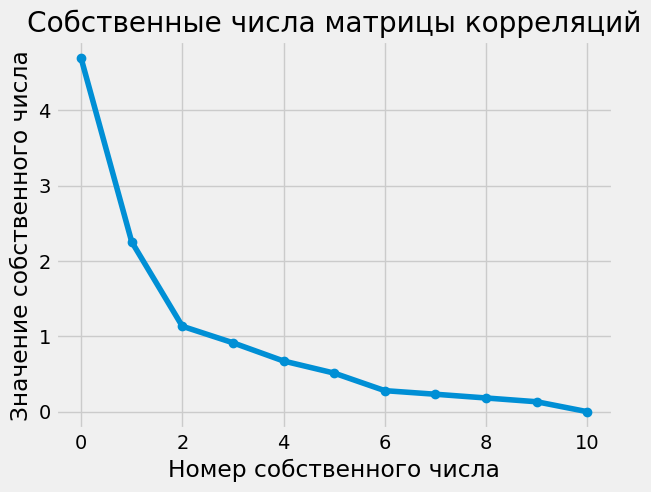

In [ ]:
# сортируем собственные числа в убывающем порядке
eigenvalues_sorted = np.sort(eigenvalues)[::-1]

# построение графика
plt.plot(eigenvalues_sorted, marker='o')
plt.title('Собственные числа матрицы корреляций')
plt.xlabel('Номер собственного числа')
plt.ylabel('Значение собственного числа')
plt.grid(True)
plt.show()

Как видно на графике, номер 3 и дальше имеют значение меньше 1. Значит у нас осталось 3 фактора от 0 до 2.

In [ ]:
# создаем объект PCA с указанием количества компонент (в данном случае 3)
pca = PCA(n_components=3)

model = pca.fit(df)
result = model.transform(df)

# получаем собственные векторы (главные компоненты)
eigenvectors = pca.components_

# собираем в датасет и далее выводим
ps = pd.DataFrame(eigenvectors.T, index=df.columns)
ps.sort_values(by=1,ascending=False)

,0,1,2
Life Ladder,0.119138,0.820348,-0.516639
Log GDP Per Capita,0.135818,0.523403,0.832480
Social Support,0.010482,0.062128,0.008246
Freedom To Make Life Choices,0.007397,0.050587,-0.075516
Positive Affect,0.003552,0.049256,-0.078702
Generosity,0.000392,0.034197,-0.102256
Confidence In National Government,-0.004884,0.012157,-0.089226
Negative Affect,-0.001755,-0.033532,0.000590
Perceptions Of Corruption,-0.008597,-0.075610,0.059492
Perceptions Of Corruption,-0.008597,-0.075610,0.059492


Как видно, уровень счастья внес самый большой вклад во второй компонент; у первого компонента он на 3ем месте по значимости, а у 3ого имеет ярко выраженную обратную зависимость, что тоже имеет самое большое значение из всех, но с конца.

In [ ]:
factrs = pd.DataFrame(result)
factrs.head()

,0,1,2
0,-13.073184,-0.307931,-0.108959
1,-12.674280,0.292884,-0.350492
2,-12.319192,0.599395,-0.441416
3,-12.140531,-0.240225,0.003360
4,-11.841205,-0.285376,0.052371


In [ ]:
# посмотрим новый датасет с факторами.
new_df_pca = pd.merge(world_happ['Country Name'], factrs, left_index=True, right_index=True)
new_df_pca.head(10)

,Country Name,0,1,2
0,Afghanistan,-13.073184,-0.307931,-0.108959
1,Afghanistan,-12.674280,0.292884,-0.350492
2,Afghanistan,-12.319192,0.599395,-0.441416
3,Afghanistan,-12.140531,-0.240225,0.003360
4,Afghanistan,-11.841205,-0.285376,0.052371
5,Afghanistan,-11.570025,-0.516192,0.183176
6,Afghanistan,-11.329796,-0.949220,0.405688
7,Afghanistan,-10.935805,-0.320112,-0.037867
8,Afghanistan,-10.585907,-0.162320,-0.202836
9,Afghanistan,-10.456548,-1.542576,0.637078


In [ ]:
# и проверим полноту информации, полученную тремя компонентами. Иными словами, проверим потери от исходного датасета.
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)
print(f"Три фактора описывают {round(sum(explained_variance_ratio)*100, 1)}% информации.")

[0.97745178 0.01486001 0.00490766]
Три фактора описывают 99.7% информации.


Отличный показатель, почти 100%. <br>
На основе этого датасета будем проверять гипотезу следующим образом: возьмем его за эталонный и будем проверять, как будет меняться сходство кластеров до и после добавления данных из датасета с музыкой, который мы тоже обработаем с помощью PCA.

##**Датасет с музыкой**##

Теперь посмотрим на датасет с музыкой. Судя по описанию автора, чем выше значение в столбце того или иного жанра у страны, тем более там популярны исполнители этих жанров. Тут искажает картину столбец "Other". Куда автор внес жанры, которые близки с основным, но таковыми не являются или на странице исполнителей они написаны иначе, чем основные, о чем я и писал во введении. Сложно сказать, насколько это повлияет на результат, но можно попробовать различные способы обработки этого столбца для увеличения точности.

In [ ]:
music.head(5)

# названия стран написаны в нижнем регистре, это нужно учесть при обьединении таблиц.

,Unnamed: 0,Country,Hip hop/Rap/R&b,EDM,Pop,Rock/Metal,Latin/Reggaeton,Other
0,0,australia,31,15.0,65,17.0,0.0,8
1,1,canada,39,12.0,64,14.0,0.0,10
2,2,china,11,23.0,108,4.0,0.0,21
3,3,india,25,1.0,39,0.0,0.0,55
4,4,mexico,38,0.0,18,2.0,57.0,43


In [ ]:
print("Кол-во стран в датасете с музыкой:" , music['Country'].unique().size)

Кол-во стран в датасете с музыкой: 67


In [ ]:
del music['Unnamed: 0']

In [ ]:
music.describe()

,Hip hop/Rap/R&b,EDM,Pop,Rock/Metal,Latin/Reggaeton,Other
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,34.657534,5.698630,38.397260,4.726027,21.273973,14.232877
std,24.361980,8.835982,20.743633,5.388414,38.441969,12.698994
min,0.000000,0.000000,8.000000,0.000000,0.000000,1.000000
25%,16.000000,0.000000,25.000000,0.000000,0.000000,7.000000
50%,32.000000,1.000000,33.000000,3.000000,0.000000,10.000000
75%,50.000000,7.000000,50.000000,7.000000,32.000000,19.000000
max,158.000000,39.000000,113.000000,20.000000,219.000000,78.000000


Как видно, есть жанры музыки с нулевыми показателями, что может быть очень далеко от правды, т.к. едва ли есть страны, где совсем никто не слушает тот или иной жанр. Это тоже дает представление о том, что с датасетом могут быть проблемы.

<Figure size 1000x800 with 0 Axes>

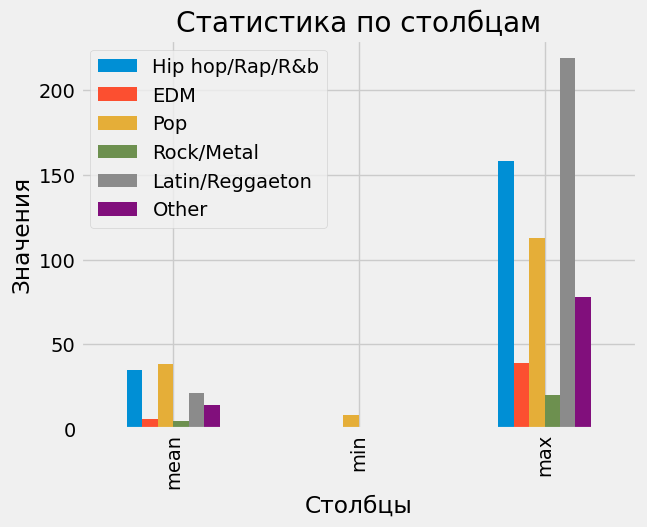

In [ ]:
plt.figure(figsize=(10, 8))

ax = music.describe().loc[['mean', 'min', 'max']].plot(kind='bar')
ax.set_title('Статистика по столбцам')
ax.set_xlabel('Столбцы')
ax.set_ylabel('Значения')
plt.show()

Диаграмма наглядно показывает, что самым популярным жанром является поп(самое высокое среднее значение), что неудивительно. У него и минимальное значение не равно 0, что тоже указывает на популярность. При этом самое большое значение у латинской\регитона, что объсяняется ростом его популярности в последнее десятилетие во всем мире.

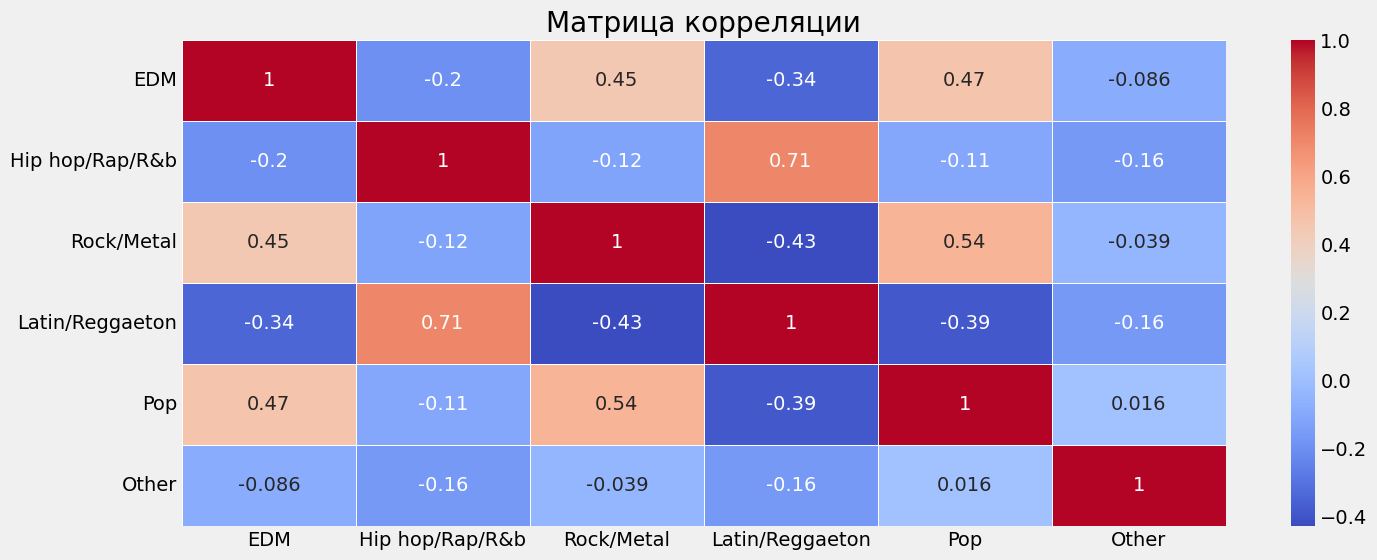

In [ ]:
df_1 = music[['EDM',
              'Hip hop/Rap/R&b',
              'Rock/Metal',
              'Latin/Reggaeton',
              'Pop',
              'Other'
]]
correlation_matrix_1 = df_1.corr()
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix_1, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Матрица корреляции")
plt.show()

Матрица корреляции в данном случае больше показывает близость\удаленность жанров. Например хип-хоп и латинская мызыка имеют самую большую корреляцию, что показывает их близость в музыкальном плане, т.к. люди их слушают вместе и далеки от рока, что показывает отрицательное значение корреляции этих столбцов.<br>
Возможно, это поможет нам выделить факторы, которые помогут в кластеризации.

In [ ]:
# находим собственные числа
eigenvalues_1, _ = np.linalg.eig(correlation_matrix_1)

# выводим результат
print("Собственные числа:", eigenvalues_1)

Собственные числа: [2.52758934 1.34857083 0.21334907 0.57153358 0.45327403 0.88568315]


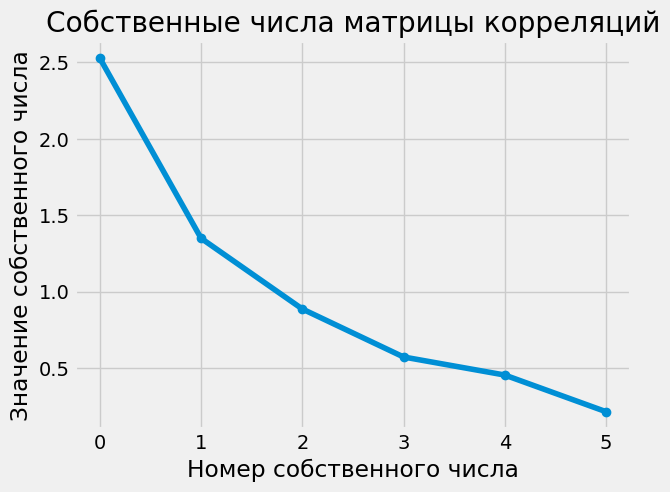

In [ ]:
# сортируем собственные числа в убывающем порядке
eigenvalues_1_sorted = np.sort(eigenvalues_1)[::-1]

# построение графика
plt.plot(eigenvalues_1_sorted, marker='o')
plt.title('Собственные числа матрицы корреляций')
plt.xlabel('Номер собственного числа')
plt.ylabel('Значение собственного числа')
plt.grid(True)
plt.show()

По графику видно, что следует взять 2 фактора, но проверка показала, что они опишут только 84% информации. Посмотрим, как это повлияет на дальнейший анализ.

In [ ]:
# Создаем объект PCA с указанием количества компонент (в данном случае 3)
pca_1 = PCA(n_components=2)

model_1 = pca_1.fit(df_1)
result_1 = model_1.transform(df_1)

eigenvectors_1 = pca_1.components_ # Получаем собственные векторы (главные компоненты)
ps_1 = pd.DataFrame(eigenvectors_1.T, index=df_1.columns) # Собираем в датасет и далее выводим

ps_1.sort_values(by=1,ascending=False)

,0,1
Pop,-0.204118,0.842105
Hip hop/Rap/R&b,0.446860,0.491985
EDM,-0.074744,0.163849
Rock/Metal,-0.051755,0.122840
Latin/Reggaeton,0.864694,-0.038357
Other,-0.051869,-0.073499


In [ ]:
factrs_1 = pd.DataFrame(result_1)
factrs_1.head()

,0,1
0,-26.467163,24.908736
1,-22.412405,26.995442
2,-44.780881,50.037959
3,-24.352825,-7.774550
4,35.624073,-20.285494


In [ ]:
# Посмотрим новый датасет музыки с факторами.
new_df_1_pca = pd.merge(music['Country'], factrs_1, left_index=True, right_index=True)
new_df_1_pca.head(10)

,Country,0,1
0,australia,-26.467163,24.908736
1,canada,-22.412405,26.995442
2,china,-44.780881,50.037959
3,india,-24.352825,-7.774550
4,mexico,35.624073,-20.285494
5,russia,-22.244569,6.508978
6,usa,5.560380,3.246405
7,colombia,67.424310,-9.431316
8,france,-14.926850,16.378518
9,italy,-11.871448,4.290435


Эти признаки будут добавлены к эталонному датасету и будет создан датасет, который мы и будем сравнивать с эталонным. <br>
Учитывая данные из второго датасета, я готов принять точность в диапазоне 60-70%. Это даст повод более детально изучить эту тему и собрать более достоверные данные для более точного и глубого анализа.

In [ ]:
# проверим потери от исходного датасета.
explained_variance_ratio_1 = pca_1.explained_variance_ratio_
print(explained_variance_ratio_1)
print(f"Три фактора описывают {round(sum(explained_variance_ratio_1)*100, 1)}% информации.")

[0.69051134 0.15789699]
Три фактора описывают 84.8% информации.


##**Проверка схождести списков стран**##

In [ ]:
mus_list = music['Country'].to_list()

In [ ]:
hap_list = new_df_pca['Country Name'].str.lower().to_list()

In [ ]:
from collections import Counter

# функция для проверки пересечий списков стран из двух датасетов. В итоге, мы получим список стран, которые есть в обоих датасетах.
def intersection_lists(list1, list2):
    # преобразуем списки в множества для нахождения общих элементов
    set1 = set(list1)
    set2 = set(list2)

    # находим пересечение множеств
    intersection = set1.intersection(set2)

    return intersection

In [ ]:
country_list = intersection_lists(mus_list, hap_list)
print(len(country_list))
print(sorted(country_list))

47
['argentina', 'australia', 'austria', 'bolivia', 'brazil', 'bulgaria', 'canada', 'chile', 'colombia', 'denmark', 'ecuador', 'egypt', 'finland', 'france', 'germany', 'greece', 'guatemala', 'honduras', 'hungary', 'iceland', 'india', 'indonesia', 'ireland', 'israel', 'italy', 'japan', 'lithuania', 'malaysia', 'mexico', 'mongolia', 'morocco', 'netherlands', 'nicaragua', 'norway', 'pakistan', 'panama', 'paraguay', 'peru', 'philippines', 'poland', 'portugal', 'romania', 'russia', 'singapore', 'spain', 'sweden', 'switzerland']


В итоговом датасете останется 47 стран.

In [ ]:
# отфильтруем датасеты, оставив там страны из общего списка

new_df_pca = new_df_pca[new_df_pca['Country Name'].str.lower().isin(country_list)]

In [ ]:
new_df_1_pca = new_df_1_pca[new_df_1_pca['Country'].str.lower().isin(country_list)]

In [ ]:
len(new_df_pca['Country Name'].value_counts())

47

In [ ]:
len(new_df_1_pca['Country'].value_counts())

47

Кол-во стран совпадает в обоих датасетах.

In [ ]:
new_df_pca.columns.to_list()

['Country Name', 0, 1, 2]

In [ ]:
# так же приведем к нижнему регистру названия стран в датасете с уровнем счастья

new_df_pca['Country Name'] = new_df_pca['Country Name'].str.lower()
new_df_pca.head()

,Country Name,0,1,2
43,argentina,3.663838,0.734125,-0.177349
44,argentina,3.788317,0.747893,-0.190145
45,argentina,3.799978,0.494716,-0.076395
46,argentina,3.806143,0.177763,0.147049
47,argentina,3.820964,-0.055766,0.247047


In [ ]:
new_df_pca = new_df_pca.reset_index().drop(['index'], axis = 1)
new_df_1_pca = new_df_1_pca.reset_index().drop(['index'], axis = 1)

In [ ]:
new_df_1_pca.head()

,Country,0,1
0,australia,-26.467163,24.908736
1,canada,-22.412405,26.995442
2,india,-24.352825,-7.774550
3,mexico,35.624073,-20.285494
4,russia,-22.244569,6.508978


Т.к. в датасете с индексом счастья статистика разбита по годам, я возьму усредненные значения для каждой страны, т.к. в датасете с музыкой нет такого разбиения и итоговый результат может исказить данные

In [ ]:
# функция для усреднения значений по годам для каждой страны
def factr_mean(data):
  result_df = pd.DataFrame(columns=['Country Name', '0', '1', '2'])

  # цикл по списку стран
  for i in country_list:

      # фильтруем датасет по названию страны
      filtered_df = data.loc[data['Country Name'] == i]

      # создаем строку с названием страны и средними значениями факторов
      new_row = {'Country Name': i, '0': round(filtered_df[0].mean(), 6), '1': round(filtered_df[1].mean(), 6), '2': round(filtered_df[2].mean(), 6)}

      # добавляем новую строку с использованием append
      result_df = result_df._append(new_row, ignore_index=True)

  return result_df

In [ ]:
# аналогичная функция для датасета с музыкой, т.к. там оказалось несколько записей за разные года
def factr_mean_1(data):
  result_df = pd.DataFrame(columns=['Country Name', '3', '4'])

  for i in country_list:

      filtered_df = data.loc[data['Country'] == i]

      new_row = {'Country Name': i, '3': round(filtered_df[0].mean(), 6), '4': round(filtered_df[1].mean(), 6)}

      result_df = result_df._append(new_row, ignore_index=True)

  return result_df

In [ ]:
result_new_df = factr_mean(new_df_pca)

In [ ]:
result_new_df1 = factr_mean_1(new_df_1_pca)

In [ ]:
result_new_df1.head()

,Country Name,3,4
0,philippines,-23.171719,-8.847588
1,paraguay,52.209118,-6.424750
2,mexico,35.624073,-20.285494
3,switzerland,-20.375665,23.635019
4,japan,-39.280234,4.894783


##Создание новых датасетов##

In [ ]:
reference_data = result_new_df.copy()

In [ ]:
reference_data.head()

,Country Name,0,1,2
0,philippines,-6.049353,0.804305,0.879941
1,paraguay,5.545211,0.208730,0.327021
2,mexico,-10.290807,0.488242,-0.316109
3,switzerland,-10.738082,-0.784007,0.243457
4,japan,-2.497128,-0.065671,0.277503


In [ ]:
reference_data.describe()

,0,1,2
count,47.000000,47.000000,47.000000
mean,0.448106,0.020549,0.087122
std,6.079150,0.514567,0.359639
min,-14.397755,-1.016877,-0.783257
25%,-4.252832,-0.343382,-0.169620
50%,2.200936,-0.078856,0.139565
75%,5.277553,0.358620,0.290122
max,8.895433,1.109957,0.937780


In [ ]:
result_new_df1.head()

,Country Name,3,4
0,philippines,-23.171719,-8.847588
1,paraguay,52.209118,-6.424750
2,mexico,35.624073,-20.285494
3,switzerland,-20.375665,23.635019
4,japan,-39.280234,4.894783


In [ ]:
result_new_df1.describe()

,3,4
count,47.000000,47.000000
mean,-2.575992,-0.358579
std,34.736471,21.238387
min,-39.280234,-33.254962
25%,-25.692194,-10.752116
50%,-20.375665,-2.907731
75%,24.996390,7.111436
max,68.237427,99.970542


In [ ]:
test_data = pd.merge(result_new_df, result_new_df1, on='Country Name')

In [ ]:
test_data.head()

,Country Name,0,1,2,3,4
0,philippines,-6.049353,0.804305,0.879941,-23.171719,-8.847588
1,paraguay,5.545211,0.208730,0.327021,52.209118,-6.424750
2,mexico,-10.290807,0.488242,-0.316109,35.624073,-20.285494
3,switzerland,-10.738082,-0.784007,0.243457,-20.375665,23.635019
4,japan,-2.497128,-0.065671,0.277503,-39.280234,4.894783


In [ ]:
test_data.describe()

,0,1,2,3,4
count,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.448106,0.020549,0.087122,-2.575992,-0.358579
std,6.079150,0.514567,0.359639,34.736471,21.238387
min,-14.397755,-1.016877,-0.783257,-39.280234,-33.254962
25%,-4.252832,-0.343382,-0.169620,-25.692194,-10.752116
50%,2.200936,-0.078856,0.139565,-20.375665,-2.907731
75%,5.277553,0.358620,0.290122,24.996390,7.111436
max,8.895433,1.109957,0.937780,68.237427,99.970542


Теперь мы имеем два датасета: reference_data - эталонный и test_data - который будем проверять, содержащий все факторы из обоих датасетов.

#**Модели**

Используем метод локтя, для определения количества класстеров. Точка на графике, в которой он начнет выпрямляться покажет нам количество кластеров.

##**Эталонный датасет.**

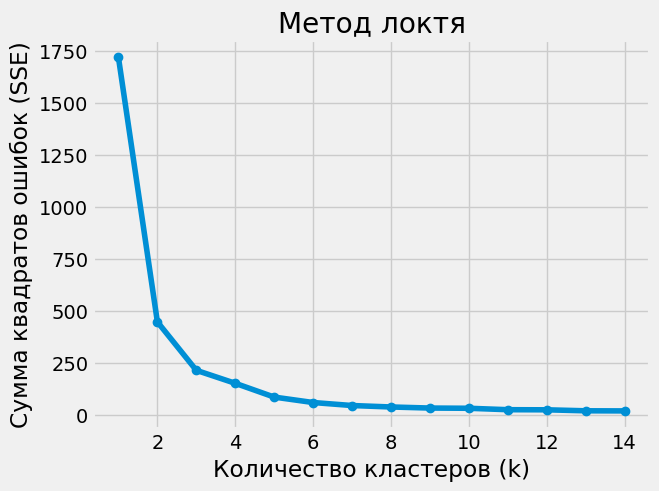

In [ ]:
X = reference_data.drop(['Country Name'], axis = 1)


inertia = []
ks = range(1, 15)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=654321).fit(X)
    inertia.append(kmeans.inertia_)

# строим график зависимости SSE от k
plt.plot(ks, inertia, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Сумма квадратов ошибок (SSE)')
plt.title('Метод локтя')
plt.show()

Попробуем разбить данные на 3,4 кластера, несмотря на границу излома ближе к 5,6. Уменьшение количества кластеров поможет их сбалансировать по кол-ву объектов, в то время как увеличение, скорее наоборот, внесет дисбаланс на таком небольшой наборе данных.

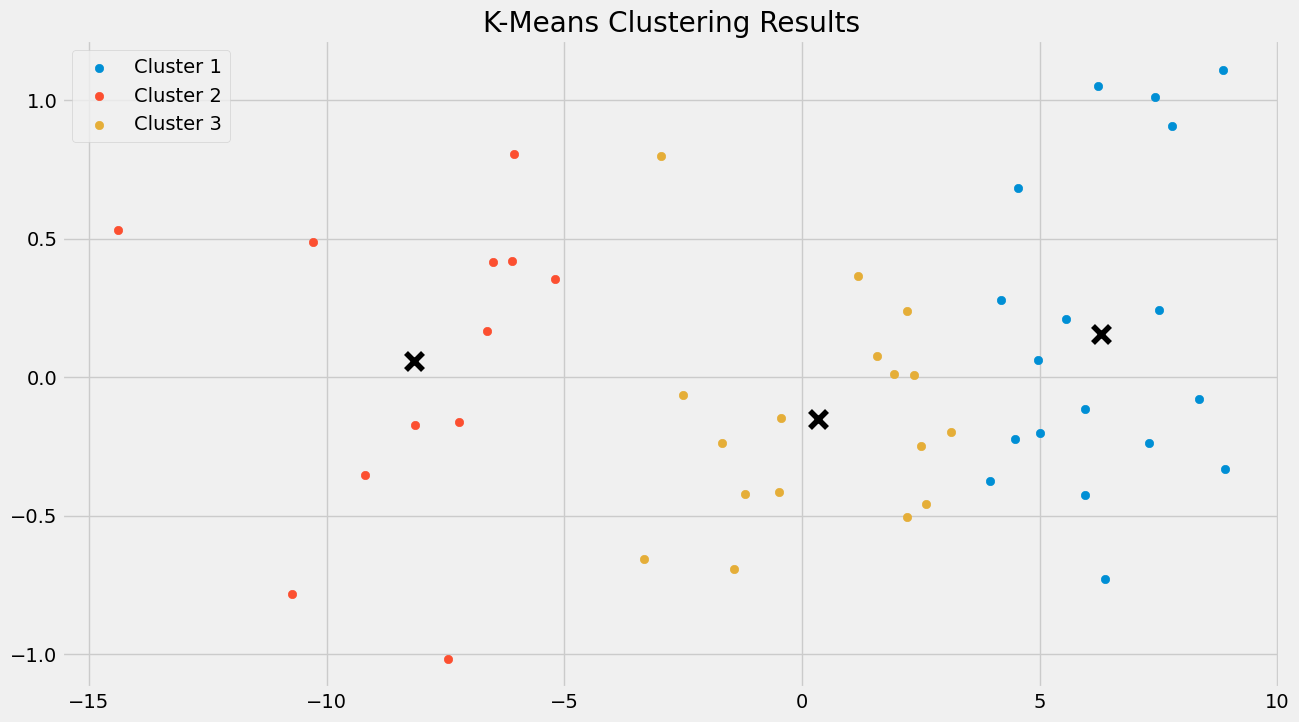

In [ ]:
# определение количества кластеров
num_clusters = 3
X = reference_data.drop(['Country Name'], axis = 1)

# применение алгоритма k-means
model = KMeans(n_clusters=num_clusters,
               init = 'k-means++',
               max_iter = 2000,
               random_state=654321).fit(X)

labels = model.labels_
centroids = model.cluster_centers_

# визуализация результатов
plt.figure(figsize=(14, 8))
for i in range(num_clusters):
  cluster_data = X[labels == i]
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Cluster {i+1}')

plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=150, c='black')
plt.title('K-Means Clustering Results')
plt.legend()
plt.show()


In [ ]:
# посмотрим распределениепо кластерам
clusters_indices = {}
for i, label in enumerate(labels):
  if label not in clusters_indices:
    clusters_indices[label] = []
    clusters_indices[label].append(i)

In [ ]:
labels = model.labels_
cluster_counts = Counter(labels)
print(f"Количество элементов в каждом кластере {cluster_counts}")

Количество элементов в каждом кластере Counter({np.int32(0): 18, np.int32(2): 17, np.int32(1): 12})


Распределение относительно равное.

##**Датасет с музыкой.**

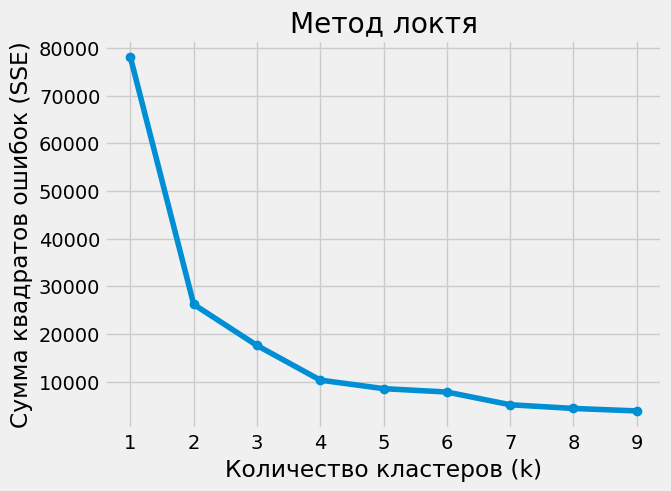

In [ ]:
Y = test_data.drop(['Country Name'], axis = 1)


inertia = []
ks = range(1, 10)
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=654321).fit(Y)
    inertia.append(kmeans.inertia_)

# строим график зависимости SSE от k
plt.plot(ks, inertia, marker='o')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Сумма квадратов ошибок (SSE)')
plt.title('Метод локтя')
plt.show()

Возьмем такое же кол-во кластеров, хотя по графику видно, что оптимально скорее 4, а не 3.

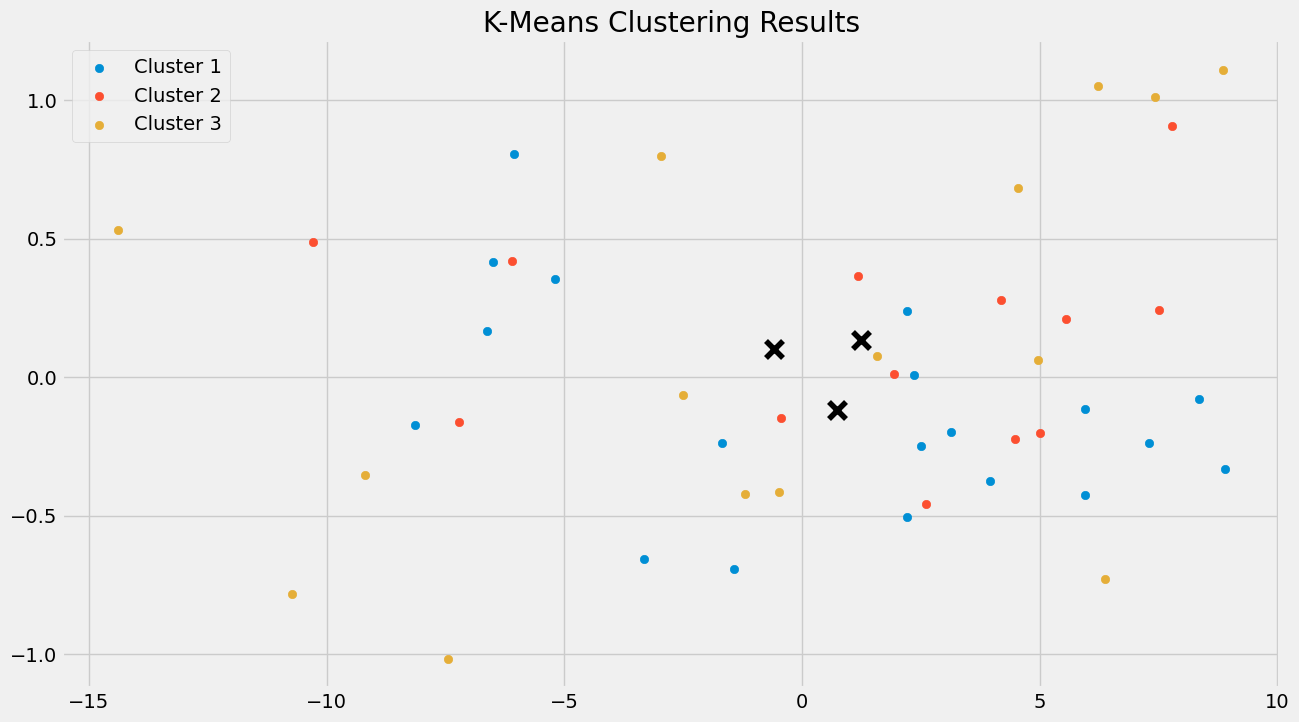

In [ ]:
# определение количества кластеров
num_clusters = 3
Y = test_data.drop(['Country Name'], axis = 1)

# применение алгоритма k-means
model_1 = KMeans(n_clusters=num_clusters,
                 init = 'k-means++',
                 max_iter = 2000,
                 random_state=654321).fit(Y)

labels_1 = model_1.labels_
centroids_1 = model_1.cluster_centers_

# визуализация результатов
plt.figure(figsize=(14, 8))
for i in range(num_clusters):
  cluster_data = Y[labels_1 == i]
  plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], label=f'Cluster {i+1}')

plt.scatter(centroids_1[:, 0], centroids_1[:, 1], marker='x', s=150, c='black')
plt.title('K-Means Clustering Results')
plt.legend()
plt.show()

In [ ]:
clusters_indices_1 = {}
for i, label_1 in enumerate(labels_1):
  if label_1 not in clusters_indices_1:
    clusters_indices_1[label_1] = []
    clusters_indices_1[label_1].append(i)

In [ ]:
labels_1 = model_1.labels_
cluster_counts_1 = Counter(labels_1)
print(f"Количество элементов в каждом кластере: {cluster_counts_1}")

Количество элементов в каждом кластере: Counter({np.int32(0): 19, np.int32(2): 15, np.int32(1): 13})


Тут тоже распределение относительное ровное, но само разбиение очень нечеткое. Скорее всего, выделить закономерности не получится.

# Оценка и итоги.

In [ ]:
fmi = fowlkes_mallows_score(labels_true=labels, labels_pred=labels_1)
print(f"Fowlkes-Mallows Index: {fmi:.2f}")


Fowlkes-Mallows Index: 0.30


Т.к. индекс Фалукса-Мелоуза сочетает в себе полноту и точность, то я решил выбрать его. Этот индекс также хорошо работает, если к существующему набору данных добавляется шум. Фоулкс и Маллоус показали, что значение индекса уменьшается по мере увеличения компонента шума, что я и делал в этой работе: к эталонном разбиению по индексу счасться добавил данные по музыке и как видно, метрика оказалась невысокой. Она не равна нулю(полному несоответствию), но и далека от единиицы(полного совпадения). <br>
Итог: т.к. мера точности не равна нулю, то скорее всего, можно предположить, что имея более объемные и точные данные по музыке можно добиться более высокой метрики и сходства, что будет подтверждением того, что индекс счастья и любимые жанры музыки имеют связь, но в текущих условиях подтвердилась нулевая гипотеза.<br>
Стоит самостоятельно собрать данные по музыке и попровать еще раз с новыми данными.